In [1]:
# !pip install SimPEG

In [2]:
import numpy as np
import scipy.sparse as sp
from SimPEG import Mesh, Utils, Solver
from scipy.constants import mu_0, epsilon_0
%pylab inline

Populating the interactive namespace from numpy and matplotlib


# Sensitivity computuation for 1D magnetotelluric (MT)  problem

##  Purpose

With [SimPEG's](http://simpeg.xyz) mesh class, we descretize sensitivity function for a 1D magnetotelluric problem. Rather than generating full sensitivity matrix, we compute forwrad (`Jvec`) and adjoint (`Jtvec`) functional that can evalaute matrix-vector product. When computing senstivity functions, we also consider different forms of data: a) real and imaginary parts of impedance and b) apparaent resistivity. There are some milestones to be accomplished:

- Break apart senstivity function, $J_{\sigma}$ into to parts then derive each of them (using chain rules):

$$ 
J_{\sigma} = \frac{d P(u)}{d \sigma} = \frac{d P(u)}{d u} \frac{d u}{d \sigma}
$$

- Compute forward and adjoint sensitivity function: `Jvec` and `Jtvec`

- Test `Jvec` and `Jtvec`: Order test and Adjoint test

## Discretzation (forward simulation)

We define physical properties at cell centers, and stagger the electric and magnetic fields

- $\sigma$, $\mu$, $\epsilon$ : cell centers
- $E_x$: cell centers
- $H_y$: faces

<img src="./images/1DMT_discretize.png" width=200px> 

and use a finite difference approach to define the operators, this gives us the discrete system of equations

$$
\underbrace{
    \begin{bmatrix}
        \mathbf{Grad} & \imath \omega \mathbf{M}^{f}_{\mu} \\[0.3em]
        \mathbf{M}^{cc}_{\hat{\sigma}} & \mathbf{Div}           \\[0.3em]
    \end{bmatrix}
}_{\mathbf{A}}
\underbrace{
    \begin{bmatrix}
       \mathbf{e_x} \\[0.3em]
       \mathbf{h_y} \\[0.3em]
    \end{bmatrix}
}_{\mathbf{u}}
=
\underbrace{
    \begin{bmatrix}
       - \mathbf{B}\mathbf{e_x}^{BC} \\[0.3em]
       \boldsymbol{0} \\[0.3em]
    \end{bmatrix}
}_{\mathbf{rhs}}
$$

with 

- $\mathbf{e_x}$: Discrete $E_x$, on cell centers $[\text{nC} \times 1]$

- $\mathbf{h_y}$: Dicrete $H_x$, on cell faces $[(\text{nC}+1) \times 1]$

- $ \mathbf{Grad}$: Discrete gradient operator $[\text{nC} \times (\text{nC}+1)]$

- $ \mathbf{Div}$: Discrete divergence operator $[(\text{nC}+1) \times \text{nC}]$

- $\mathbf{M}^{f}_{\boldsymbol{\mu}} = \mathbf{diag}(\mathbf{Av^{cc2f}}  \boldsymbol{\mu})$ $[(\text{nC}+1) \times (\text{nC}+1)]$

- $\mathbf{M}^{cc}_{\boldsymbol{\hat{\sigma}}} = \mathbf{diag}(\boldsymbol{\hat{\sigma}})$ $[\text{nC} \times \text{nC}]$

- $\mathbf{B} \mathbf{e_x}^{BC}$ handles the boundary conditions

## What is data?

Measured data in general can be defined as:

$$ \mathbf{d} = P(\mathbf{u}) $$

where $P(\cdot)$ is a evaluation functional which takes a solution vector $\mathbf{u}$ ouputs data at a receiver location. 
We consdier two different type of data: 

- real and imaginary parts of the impedance ($Z_{xy}$)

- apparaent resistivity and phase

For the first case, we consider complex impedance ($Z_{xy}$) as our data, then $Z_{xy}$ can be evaluated from the solution vector $\mathbf{u}$:

$$ \mathbf{d} = Z_{xy} = - \mathbf{P}_{0}(1 / \mathbf{u}) $$

From complex-values $Z_{xy}$, we can compute real and imagniary part of the $Z_{xy}$ then the data can be defined as:

$$\mathbf{d} =  \begin{bmatrix}
       Re[Z_{xy}]  \\[0.3em]
       Im[Z_{xy}]  \\[0.3em]
     \end{bmatrix}$$

Similarly, for the second case the data can be evaluated from $Z_{xy}$. 


$$\mathbf{d} =  \begin{bmatrix}
       \rho_a \\[0.3em]
       \phi  \\[0.3em]
     \end{bmatrix}$$

where 

$$ \rho_a = \frac{1}{\mu_0\omega} |Z_{xy}|^2 $$

$$ \phi = \frac{180}{\pi}tan^{-1}(\frac{Im[Z_{xy}]}{Re[Z_{xy}]}) $$

### Set up Mesh and Model

In [3]:
def skin_depth(sigma, f):
    """
    Depth at which the fields propagating through a homogeneous medium 
    have decayed by a factor of 1/e for a given frequency, f and conductivity, sigma
    """
    return 500./np.sqrt(sigma * f)

In [4]:
rho_half = 100.  # Resistivity of the halfspace in Ohm-m
sigma_half = 1./rho_half  # Conductivity is the inverse of conductivity
frequency = np.logspace(-3, 2, 25)  # frequencies at which to simulate the MT problem

skin_depth_min = skin_depth(sigma_half, frequency.max())
skin_depth_max = skin_depth(sigma_half, frequency.min())

print("The minimum skin depth is {:1.2f}m".format(skin_depth_min))
print("The maximum skin depth is {:1.2e}m".format(skin_depth_max))

The minimum skin depth is 500.00m
The maximum skin depth is 1.58e+05m


In [5]:
cs = skin_depth_min / 4.
core_extent = 5000. 
domain_extent = 2 * skin_depth_max

print("The smallest cell size is {:1.2f}m".format(cs))
print("The core region of the mesh extends {:1.2e}m".format(core_extent))
print("The mesh should extend at least {:1.2e}m".format(domain_extent))

The smallest cell size is 125.00m
The core region of the mesh extends 5.00e+03m
The mesh should extend at least 3.16e+05m


In [6]:
npad = 1  # start with 1 cell
padding_fact = 1.3  # the amount by which we will expand each cell of the padding

def padding_extent(npad):
    """
    given a number of padding cells, this computes how far the padding extends
    """
    padding_widths = cs*padding_fact**(np.arange(npad) + 1)
    return padding_widths.sum()

# keep adding padding until we are beyond the desired extent
padding_z = padding_extent(npad)
while padding_z < domain_extent:
    npad+=1
    padding_z = padding_extent(npad)
    
print("{:1.0f} padding cells extends {:1.2e}m > {:1.2e}m (2 skin depths)".format(
    npad, padding_extent(npad), domain_extent
))

25 padding cells extends 3.82e+05m > 3.16e+05m (2 skin depths)


In [7]:
ncz = np.ceil(core_extent / cs)  # number of cells in the core domain
hz = [(cs, npad, -1.3), (cs, ncz)]  # define how to construct the cell widths
mesh = Mesh.TensorMesh([hz], x0='N')  # construct a 1D Tensor Mesh

print("There are {:1.0f} cells in the mesh. The mest extends {:1.2e}m".format(
    ncz, mesh.hx.sum()
)) 

sigma = np.ones(mesh.nC) * sigma_half

There are 40 cells in the mesh. The mest extends 3.87e+05m


### Forward simulation function

Forward simulation function `dpred` takes conductivity model (`nCx1`), and frequency (`1x1`), and outputs real and imaginary part of the impedance, $Z_{xy}$ (`2x1`). By solving $\mathbf{A} \mathbf{u}=\mathbf{rhs}$, we compute solution vector $\mathbf{u}$, then evaluate real and imaginary part of impedance at $z=0$ ($\mathbf{d} = P(\mathbf{u})$). 

In [8]:
def dpred(sigma, f=100.):
    # angular frequency
    omega = f*2.*np.pi
    # physical properties
    mu = np.ones(mesh.nC)*mu_0 # magnetic permeability values for all cells
    epsilon = np.ones(mesh.nC)*epsilon_0 # dielectric constant values for all cells
    sigmahat = sigma.copy()
    # Grad 
    mesh.setCellGradBC([['dirichlet', 'dirichlet']]) # Setup boundary conditions
    Grad = mesh.cellGrad # Gradient matrix

    # MfMu
    Mmu = Utils.sdiag(mesh.aveCC2F * mu) 
    # Mccsigma
    Msighat = Utils.sdiag(sigmahat) 
    # Div
    Div = mesh.faceDiv # Divergence matrix
    # Right Hand Side
    B = mesh.cellGradBC  # a matrix for boundary conditions
    Exbc = np.r_[0., 1.] # boundary values for Ex

    # A-matrix
    A = sp.vstack([
        sp.hstack([Grad, 1j*omega*Mmu]), # Top row of A matrix
        sp.hstack((Msighat, Div)) # Bottom row of A matrix
    ])
    # Right-hand side
    rhs = np.r_[
        -B*Exbc, 
        np.zeros(mesh.nC)
    ] 

    Ainv = Solver(A) # Factorize A matrix
    u = Ainv*rhs   # Solve A^-1 rhs = u
    Ex = u[:mesh.nC] # Extract Ex from uution vector u
    Hy = u[mesh.nC:mesh.nC+mesh.nN] # Extract Hy from solution vector u    
    P0 = sp.coo_matrix(
        (np.r_[1.], (np.r_[0], np.r_[len(u)-1])), shape=(1, len(u))
             )
    P0 = P0.tocsr()
    Zxy = - 1./(P0*u)
    return np.r_[Zxy.real, Zxy.imag]

In [10]:
f = 100.
dpred(sigma, f=f)

array([ 0.19565167,  0.2017791 ])

## Sensitivity of datum with regard to $\sigma$:

Sensitivity function shows how much data is changed due to changes in model paramters. In general this is an important information to understand and design a geophysical survey. Further, to find a reasonable model we could use a gradient-based inversion technique, and for this case sensitivity function provide a gradient direction to find a solution. 

Sensitivity function can be defined as 

$$ J_{\sigma} = \frac{d P(u)}{d \sigma}$$

To obtain above sensitivity function in discrete space, we differentiate 

$$\mathbf{A}\mathbf{u} = \mathbf{rhs}$$

w.r.t ${\boldsymbol{\sigma}}$, which yields 

$$ \frac{d \mathbf{A}}{d {\boldsymbol{\sigma}}}\mathbf{u} +  \mathbf{A} \frac{d \mathbf{u} }{d {\boldsymbol{\sigma}}}=  0 $$

Rearranging and multiplyting $\mathbf{A}^{-1}$ in both sides yields

$$ \frac{d \mathbf{u} }{d {\boldsymbol{\sigma}}}=  -\mathbf{A}^{-1}\frac{d \mathbf{A}}{d {\boldsymbol{\sigma}}}\mathbf{u} $$

Consideration evaluation, $\mathbf{d} = P(\mathbf{u})$ we obtain

$$ \mathbf{J}_{{\boldsymbol{\sigma}}}  = 
\frac{\partial P(\mathbf{u})}{\partial {\mathbf{u}}}\Big(\frac{d \mathbf{u} }{d {\boldsymbol{\sigma}}}\Big) = 
-\frac{\partial P(\mathbf{u})}{\partial {\mathbf{u}}} \Big(\mathbf{A}^{-1}\frac{d \mathbf{A}}{d {\boldsymbol{\sigma}}}\mathbf{u}\Big) $$

Two derivatives need to be derived:

$$\frac{d \mathbf{A}}{d \boldsymbol{\sigma}}\mathbf{u}=?$$

$$\frac{\partial P(\mathbf{u})}{\partial \mathbf{u}}=?$$

The first one is straight forward having in mind that we are taking derivative vector ($\mathbf{A}\mathbf{u}$) with vector ($\boldsymbol{\sigma}$) yielding matrix:

$$ 
\frac{d \mathbf{A}}{d \boldsymbol{\sigma}}\mathbf{u} =
\begin{bmatrix}
    \mathbf{0} \\[0.3em]
    \mathbf{diag}(\mathbf{E}_x) \\[0.3em]
\end{bmatrix}
$$

For the other one we consider when the data is defined as real and imaginary parts of $Z_{xy} = -\mathbf{P}_0\frac{1}{\mathbf{u}}$:

Taking derivative of $Z_{xy}$ w.r.t. $\mathbf{u}$ yields
$$
\frac{\partial Z_{
xy}}{\partial \mathbf{u}}=
\mathbf{P}_0\frac{1}{\mathbf{u}^2}
$$

$$ 
\frac{\partial P(\mathbf{u})}{\partial \mathbf{u}}=
\begin{bmatrix}
   \frac{\partial Re[Z_{xy}]}{\partial \mathbf{u}}  \\[0.3em]
   \frac{\partial Im[Z_{xy}]}{\partial \mathbf{u}}  \\[0.3em]
\end{bmatrix}  
=
\begin{bmatrix}
   Re[\mathbf{P}_0\frac{1}{\mathbf{u}^2}]  \\[0.3em]
   Im[\mathbf{P}_0\frac{1}{\mathbf{u}^2}]  \\[0.3em]
\end{bmatrix}          
$$


Now we can form sensitivity matrix $\mathbf{J}_{\sigma}$ by combining above equations:

$$ \mathbf{J}_{{\boldsymbol{\sigma}}}  = 
-\frac{\partial P(\mathbf{u})}{\partial {\mathbf{u}}} \Big(\mathbf{A}^{-1}\frac{d \mathbf{A}}{d {\boldsymbol{\sigma}}}\mathbf{u}\Big) $$

Deriving sensitivity for apparent resistivity and phase is possible, but this requires additional details hence, we focus on our attention to real and imaginary parts of impedance. 

In [11]:
# angular frequency
omega = f*2*np.pi

# physical properties
sigma = np.ones(mesh.nC)*sigma_half # conductivity values for all cells
mu = np.ones(mesh.nC)*mu_0 # magnetic permeability values for all cells
epsilon = np.ones(mesh.nC)*epsilon_0 # dielectric constant values for all cells
sigmahat = sigma.copy()

# Grad 
mesh.setCellGradBC([['dirichlet', 'dirichlet']]) # Setup boundary conditions
Grad = mesh.cellGrad # Gradient matrix

# MfMu
Mmu = Utils.sdiag(mesh.aveCC2F * mu) 
# Mccsigma
Msighat = Utils.sdiag(sigmahat) 
# Div
Div = mesh.faceDiv # Divergence matrix
# Right Hand Side
B = mesh.cellGradBC  # a matrix for boundary conditions
Exbc = np.r_[0., 1.] # boundary values for Ex

# A-matrix
A = sp.vstack([
    sp.hstack([Grad, 1j*omega*Mmu]), # Top row of A matrix
    sp.hstack((Msighat, Div)) # Bottom row of A matrix
])
# Right-hand side
rhs = np.r_[
    -B*Exbc, 
    np.zeros(mesh.nC)
] 

In [12]:
Ainv = Solver(A) # Factorize A matrix
u = Ainv*rhs   # Solve A^-1 rhs = u
Ex = u[:mesh.nC] # Extract Ex from uution vector u
Hy = u[mesh.nC:mesh.nC+mesh.nN] # Extract Hy from solution vector u    

P0 = sp.coo_matrix(
    (np.r_[1.], (np.r_[0], np.r_[len(u)-1])), shape=(1, len(u))
         )
P0 = P0.tocsr()

dAdsig_u = sp.vstack((Utils.spzeros(int(mesh.nC+1), mesh.nC), Utils.sdiag(Ex)))
dudsig = - (Ainv * (dAdsig_u.toarray()))
dZdsig = P0 * (Utils.sdiag(1./(u**2)) * dudsig)
J = np.vstack((dZdsig.real, dZdsig.imag))

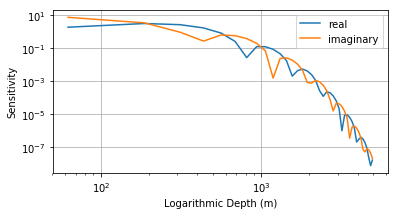

In [13]:
figsize(6, 3)
core_inds = mesh.vectorCCx > -core_extent
plt.loglog(-mesh.vectorCCx[core_inds], abs(J[0,core_inds]))
plt.loglog(-mesh.vectorCCx[core_inds], abs(J[1,core_inds]))
plt.grid(True)
plt.legend(("real", "imaginary"))
plt.xlabel("Logarithmic Depth (m)")
plt.ylabel("Sensitivity")

## Computing sensitivity-vector products:

For 1D MT problem, sensitivity matrix ($N\times M$) can be small, hence generating sensitivity will not be a big deal. However, for instance any 3DEM problem, generating sensitivity matrix will require huge computatiion costs. To minimize that we only compute sensitivity-vector product. In forward case we compute:

$$ \mathbf{Jv} = \mathbf{J}_{\boldsymbol{\sigma}} \mathbf{v} $$

Similarly, in adjoint case, we compute

$$ \mathbf{Jtv} = \mathbf{J}_{\boldsymbol{\sigma}}^{T} \mathbf{v} $$

Computing $\mathbf{Jv}$ and $\mathbf{Jtv}$ are straight forward from above derivation. 

$$ \mathbf{J}_{{\boldsymbol{\sigma}}}^T \mathbf{v} 
=  - (\frac{d \mathbf{A}}{d {\boldsymbol{\sigma}}}\mathbf{u} )^T
(\mathbf{A}^{T})^{-1} \frac{\partial P(\mathbf{u})}{\partial {\mathbf{u}}}^T \mathbf{v} $$

One function computes forward sensitivity-vector product as `Jvec` and the other function computes adjoint sensitivity-vector product are named as `Jtvec`. 

In [14]:
def Jvec(sigma, v, f=100.):
    mu = np.ones(mesh.nC)*mu_0 # magnetic permeability values for all cells
    epsilon = np.ones(mesh.nC)*epsilon_0 # dielectric constant values for all cells
    omega = 2*np.pi*f # Angular frequency (rad/s)
    sigmahat = sigma # Assume sigmahat = sigma
    # In reality ...
    #         sigmahat = sigma + 1j*epsilon*omega # sigmahat = sigma + 1j*omega*epsilon
    Div = mesh.faceDiv # Divergence matrix
    mesh.setCellGradBC([['dirichlet', 'dirichlet']]) # Setup boundary conditions
    Grad = mesh.cellGrad # Gradient matrix
    B = mesh.cellGradBC  # a matrix for boundary conditions
    Exbc = np.r_[0., 1.] # boundary values for Ex
    Msighat = Utils.sdiag(sigmahat) 
    Mmu = Utils.sdiag(mesh.aveCC2F * mu) 

    # A-matrix
    A = sp.vstack([
        sp.hstack([Grad, 1j*omega*Mmu]), # Top row of A matrix
        sp.hstack((Msighat, Div)) # Bottom row of A matrix
    ])

    # Right-hand side
    rhs = np.r_[
        -B*Exbc, 
        np.zeros(mesh.nC)
    ] 

    Ainv = Solver(A) # Factorize A matrix
    u = Ainv*rhs   # Solve A^-1 rhs = u
    Ex = u[:mesh.nC] # Extract Ex from uution vector u
    Hy = u[mesh.nC:mesh.nC+mesh.nN] # Extract Hy from solution vector u    
    P0 = sp.coo_matrix(
        (np.r_[1.], (np.r_[0], np.r_[len(u)-1])), shape=(1, len(u))
             )
    P0 = P0.tocsr()
    Zxy = - 1./(P0*u)

    dAdsig_u_v = np.r_[np.zeros_like(Hy), Utils.sdiag(Ex)*v]
    dudsig_v = - (Ainv * (dAdsig_u_v))
    dZdsig_v = P0 * (Utils.sdiag(1./(u**2)) * dudsig_v)
    dZrdsig_v = dZdsig_v.real
    dZidsig_v = dZdsig_v.imag
    return np.r_[dZrdsig_v, dZidsig_v]

### Order test: Jvec

In [15]:
from SimPEG import Tests
def derChk(m):
    return [dpred(m), lambda mx: Jvec(m, mx)]
Tests.checkDerivative(derChk, sigma, plotIt=False, num=3, eps=1e-20, dx=sigma*3)

==================== checkDerivative ====================
iter    h         |ft-f0|   |ft-f0-h*J0*dx|  Order
---------------------------------------------------------
 0   1.00e-01    3.454e-02     7.604e-03      nan
 1   1.00e-02    4.121e-03     9.254e-05      1.915
 2   1.00e-03    4.204e-04     9.461e-07      1.990
========================= PASS! =========================
Not just a pretty face Sgkang



True

In [16]:
def misfit(sigma, dobs=None):
    r = dpred(sigma) - dobs
    return 0.5 * np.linalg.norm(r)**2

def Jtvec(sigma, v, dtype="ri"):
    f = 100.
    mu = np.ones(mesh.nC)*mu_0 # magnetic permeability values for all cells
    epsilon = np.ones(mesh.nC)*epsilon_0 # dielectric constant values for all cells
    omega = 2*np.pi*f # Angular frequency (rad/s)
    sigmahat = sigma # Assume sigmahat = sigma
    # In reality ...
    #         sigmahat = sigma + 1j*epsilon*omega # sigmahat = sigma + 1j*omega*epsilon
    Div = mesh.faceDiv # Divergence matrix
    mesh.setCellGradBC([['dirichlet', 'dirichlet']]) # Setup boundary conditions
    Grad = mesh.cellGrad # Gradient matrix
    B = mesh.cellGradBC  # a matrix for boundary conditions
    Exbc = np.r_[0., 1.] # boundary values for Ex
    Msighat = Utils.sdiag(sigmahat) 
    Mmu = Utils.sdiag(mesh.aveCC2F * mu) 

    tempUp = sp.hstack((Grad, 1j*omega*Mmu)) # Top row of A matrix
    tempDw = sp.hstack((Msighat, Div)) # Bottom row of A matrix
    A = sp.vstack((tempUp, tempDw)) # Full A matrix
    rhs = np.r_[-B*Exbc, np.zeros(mesh.nC)] # Right-hand side   

    Ainv = Solver(A) # Factorize A matrix
    u = Ainv*rhs   # Solve A^-1 rhs = u
    Ex = u[:mesh.nC] # Extract Ex from uution vector u
    Hy = u[mesh.nC:mesh.nC+mesh.nN] # Extract Hy from solution vector u    
    P0 = sp.coo_matrix(
        (np.r_[1.], (np.r_[0], np.r_[len(u)-1])), shape=(1, len(u))
             )
    P0 = P0.tocsr()
    Zxy = - 1./(P0*u)    
    ATinv = Solver(A.T) # Factorize A matrix        
    
    PTvr = (P0.T*np.r_[v[0]]).astype(complex)
    PTvi = P0.T*np.r_[v[1]]*-1j
    dZrduT_v = Utils.sdiag((1./(u**2)))*PTvr
    dZiduT_v = Utils.sdiag((1./(u**2)))*PTvi

    dAdsiguT = sp.hstack((Utils.spzeros(mesh.nC, mesh.nN), Utils.sdiag(Ex)))

    dZrdsigT_v = - (dAdsiguT*(ATinv*dZrduT_v)).real
    dZidsigT_v = - (dAdsiguT*(ATinv*dZiduT_v)).real        
    return dZrdsigT_v + dZidsigT_v

In [17]:
sigma0 = sigma*3
dobs_ri = dpred(sigma)
r = dpred(sigma0) - dobs_ri 

Tests.checkDerivative(
    lambda m: [misfit(m, dobs=dobs_ri), Jtvec(m, r)],
    sigma0,
    plotIt=False,
    num=5
)

==================== checkDerivative ====================
iter    h         |ft-f0|   |ft-f0-h*J0*dx|  Order
---------------------------------------------------------
 0   1.00e-01    1.119e-02     1.380e-02      nan
 1   1.00e-02    2.236e-03     2.619e-04      1.722
 2   1.00e-03    2.471e-04     2.730e-06      1.982
 3   1.00e-04    2.495e-05     2.735e-08      1.999
 4   1.00e-05    2.498e-06     2.735e-10      2.000
========================= PASS! =========================
The test be workin!



True

## Adjoint tests

In [18]:
v = np.random.rand(mesh.nC)
w = np.random.rand(dobs_ri.shape[0])
wtJv = w.dot(Jvec(sigma0, v))
vtJtw = v.dot(Jtvec(sigma0, w))
passed = np.abs(wtJv - vtJtw) < 1e-10
print('Adjoint Test', np.abs(wtJv - vtJtw), passed)

('Adjoint Test', 4.4408920985006262e-16, True)
